# Covid-19: From model prediction to model predictive control

## A demo of a stochastic difference equation (SDE) SIR model

*Code by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens and prof. Jan baetens of the KERMIT research unit.*

Copyright (c) 2021 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from covid19model.models import models
from covid19model.data import mobility, sciensano, model_parameters

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
###############
## Load data ##
###############

age_classes = pd.IntervalIndex.from_tuples([(0,20),(20,60),(60,120)], closed='left')
# Initial conditions, time-integrated prepandemic contact matrices, model parameters of COVID19 SEIQRD
initN, Nc_dict, parameters, BASE_samples_dict = model_parameters.get_COVID19_SEIQRD_parameters(age_classes=age_classes)
# Google Mobility data
df_google = mobility.get_google_mobility_data(update=False)
# Sciensano public data
df_hosp, df_mort, df_cases, df_vacc = sciensano.get_sciensano_COVID19_data(update=False)
# Aggregate the data on the national level
df_hosp = df_hosp.groupby(level='date').sum()['H_in']

In [3]:
############################
## Define a draw function ##
############################

def draw_fcn(param_dict,samples_dict):
    return param_dict

In [4]:
###################################
## Define social policy function ##
###################################

from covid19model.models.time_dependant_parameter_fncs import ramp_fun
def compliance_func(t, states, param, l, effectivity):
    
    # Convert tau and l to dates
    l_days = pd.Timedelta(l, unit='D')
    # Define start and end of measures
    start_measures = pd.to_datetime('2020-03-15')
    end_measures = pd.to_datetime('2020-07-01')
    # List of transitioning dates
    change_days = [start_measures,
                   start_measures + l_days,
                   end_measures]
    
    # List of transitioning values
    change_values = [param,
                     ramp_fun(param, effectivity*param, t, start_measures, l),
                     param * effectivity,
                     param * effectivity]
    # Return appropriate policy
    try:
        return change_values[[index for index,value in enumerate(change_days) if value > t][0]]
    except:
        return change_values[-1]

In [56]:
######################
## Initialize model ##
######################

# Define parameters
l = 14
effectivity = 0.18
params = {'beta': 0.016, 'gamma': 1/7, 'Nc': Nc_dict['total'], 'l': l, 'effectivity': effectivity}
# Define initial states
initial_states = {"S": initN.values, "I": np.ones(3)*df_hosp[0]/3}
# Initialize model (SDEs are discrete time models and require the discrete=True flag upon initialization)
model = models.simple_stochastic_SIR(initial_states, params, time_dependent_parameters={'Nc': compliance_func}, discrete=True)

In [103]:
########################
## Perform simulation ##
########################

n_draws = 100
start_sim = '2020-03-15'
end_sim = '2020-09-01'
out = model.sim(end_sim,start_date=start_sim,warmup=0,N=n_draws,draw_fcn=draw_fcn,samples={})

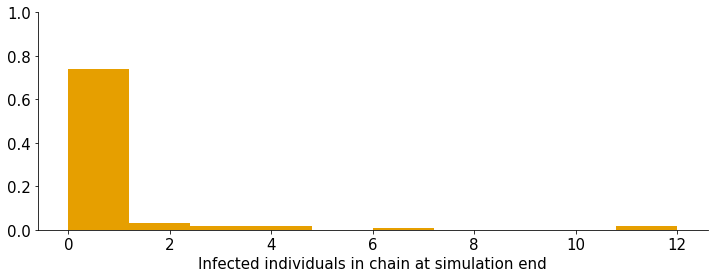

In [105]:
#################################################################
## Show distribution of infected individuals at simulation end ##
#################################################################

final_value = []
for i in range(n_draws):
    val = float(out['I'].sum(dim='Nc').isel(draws=i).isel(time=-1).values)
    final_value.append(val)
fig,ax=plt.subplots(figsize=(12,4))
ax.hist(final_value, density=True)
ax.grid(False)
ax.set_ylim([0,1])
ax.set_xlabel('Infected individuals in chain at simulation end')
plt.show()
plt.close()

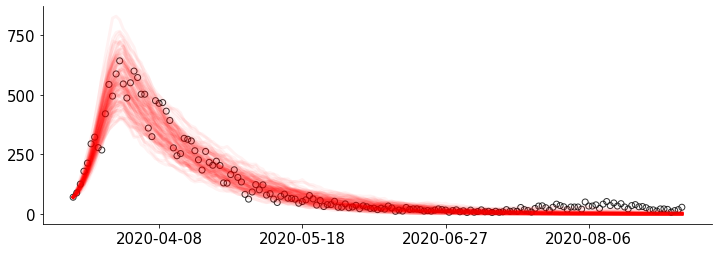

In [94]:
#######################
## Visualize results ##
#######################

fig, ax = plt.subplots(figsize=(12,4))
for i in range(n_draws):
    ax.plot(out['time'],out['I'].sum(dim='Nc').isel(draws=i), color='red', alpha = 0.05, linewidth = 3)
ax.scatter(df_hosp[start_sim:end_sim].index,df_hosp[start_sim:end_sim],color='black',alpha=0.8,linestyle='None',facecolors='none')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.grid(False)
plt.show()
plt.close()